## Data cleaning 

**Import Modules**

In [1]:
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import isnan, when, count, col

In [2]:
# Data Manipulation
import numpy as np 
import pandas as pd

In [3]:
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

**Read csv file**

We first read in the data into a spark dataframe. We let spark automatically infer the schema and it does a good job of obtaining the correct columns.

In [4]:
filename = 'data.csv'
df = spark.read.csv(filename, inferSchema=True, header = True)

**Drop Variables**

Since `id`, `name`, `release_date`, `key`, `explicit`, and `mode` are not related to our question, we drop these columns from our dataframe.

In [5]:
# Variables id, name, release_date are not related to our question.
# Thus, droping all three.
df = df.drop("id", "name", "release_date","key","explicit","mode")

**Convert Data Type**

We had to loop through the data frame and explicitly cast features as floats and ints, because the original schema assumed they were all strings.

In [6]:
floats = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness",
         "speechiness", "tempo", "valence"]
for i in floats:
        df = df.withColumn(i, df[i].cast(FloatType()))

ints = ["duration_ms", "popularity", "year"]
for i in ints:
    df = df.withColumn(i, df[i].cast(IntegerType()))

In [7]:
# With Correct Variable Type
df.createOrReplaceTempView("df")

In [8]:
df.printSchema()

root
 |-- acousticness: float (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- year: integer (nullable = true)



**Duplicates & Nulls**

We clean the dataset by removing duplicate data and any row with null entries. In addition, we subset the data to only include songs that were released after 1950.

In [9]:
# Count rows and unique rows
print('Rows = {}'.format(df.count()))
print('Distinct Rows = {}'.format(df.distinct().count()))

Rows = 174389
Distinct Rows = 170929


In [10]:
# Check
# Drop all duplicates 
df = df.dropDuplicates()
print('The number of rows with duplicate data removed = {}'.format(df.count()))

The number of rows with duplicate data removed = 170929


In [11]:
df = df.dropna()

In [12]:
# Check for NULL
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------------+-------+------------+-----------+------+----------------+--------+--------+----------+-----------+-----+-------+----+
|acousticness|artists|danceability|duration_ms|energy|instrumentalness|liveness|loudness|popularity|speechiness|tempo|valence|year|
+------------+-------+------------+-----------+------+----------------+--------+--------+----------+-----------+-----+-------+----+
|           0|      0|           0|          0|     0|               0|       0|       0|         0|          0|    0|      0|   0|
+------------+-------+------------+-----------+------+----------------+--------+--------+----------+-----------+-----+-------+----+



In [13]:
df = df.where((df.popularity > 0))
df = df.where((df.year > 1950))

**Numeric Variables & Categorical Variables**

We separated the numeric and categorical features in order to compare correlation between the numeric features and popularity.

In [14]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    #if data_type == "FloatType" or data_type == "IntType" or data_type =="String":
    else:
        num_cols.append(s.name)

In [15]:
print(num_cols)
print(cat_cols)

['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness', 'tempo', 'valence', 'year']
['artists']


In [16]:
# Correlation
import six
for i in df.columns:
    if not(isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to popularity for ", i, df.stat.corr('popularity',i))

Correlation to popularity for  acousticness -0.3027898785940275
Correlation to popularity for  danceability 0.19697086166969174
Correlation to popularity for  duration_ms 0.02557211028110442
Correlation to popularity for  energy 0.21770844824875618
Correlation to popularity for  instrumentalness -0.2247137393508837
Correlation to popularity for  liveness -0.09836944674863705
Correlation to popularity for  loudness 0.2892525963148474
Correlation to popularity for  popularity 1.0
Correlation to popularity for  speechiness 0.03657699101895756
Correlation to popularity for  tempo 0.04520927436031897
Correlation to popularity for  valence 0.02814491902318553
Correlation to popularity for  year 0.47941627184567515


## EDA

To explore the dataset, we convert the spark dataframe to pandas so we are able to utilize some of python's convienient data visualization packages.

In [17]:
df_pandas = df.toPandas()
df_pandas.head()

,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
0,0.991,['Ahmad Jamal'],0.690,174573,0.1640,0.886000,0.1290,-18.657,23,0.0451,80.099998,0.579,1951
1,0.981,['Ahmad Jamal'],0.781,173987,0.1390,0.895000,0.1130,-18.382,14,0.0442,116.013000,0.331,1951
2,0.897,['Doris Day'],0.697,146333,0.3290,0.000000,0.1910,-10.142,19,0.0420,97.853996,0.749,1951
3,0.875,"['Les Paul', 'Mary Ford']",0.300,179467,0.3790,0.000136,0.2060,-9.741,44,0.0503,71.308998,0.221,1952
4,0.889,['Cuco Sánchez'],0.569,194200,0.0507,0.000000,0.0679,-17.021,41,0.0540,117.579002,0.298,1954


### Examining Different Metrics Over the Years

We were interested in seeing if there was a relationship between our song feature data and time. We aggregated the data by year and calculated the mean Danceability, Instrumentalness, Loudness, and Tempo of the songs released during each year from 1920 to 2020.

In [18]:
df_agg = df_pandas.groupby('year').agg({'danceability':'mean', 'instrumentalness':'mean', 'loudness':'mean', 'tempo':'mean'})
df_agg.head()

,danceability,instrumentalness,loudness,tempo
year,,,,
1951,0.490494,0.292065,-14.767863,112.525696
1952,0.488723,0.236367,-14.562872,111.201584
1953,0.462916,0.394446,-15.076856,113.514893
1954,0.466878,0.296898,-14.769774,108.901169
1955,0.492357,0.231569,-13.848489,111.257248


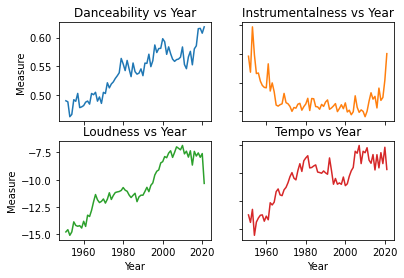

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(df_agg.index, df_agg['danceability'])
axs[0, 0].set_title('Danceability vs Year')
axs[0, 1].plot(df_agg.index, df_agg['instrumentalness'], 'tab:orange')
axs[0, 1].set_title('Instrumentalness vs Year')
axs[1, 0].plot(df_agg.index, df_agg['loudness'], 'tab:green')
axs[1, 0].set_title('Loudness vs Year')
axs[1, 1].plot(df_agg.index, df_agg['tempo'], 'tab:red')
axs[1, 1].set_title('Tempo vs Year')

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Measure')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Danceability, loudness, and tempo each increased with time after about 1950 while instrumentalness decreased on average. This leads us to believe that certain types of music became more popular as the years passed.

### Exploring Distribution of Popularity

We were interested in looking at the distribution of song popularity to see if our dataset was overly skewed by a certain value. 

/Users/jasonyu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


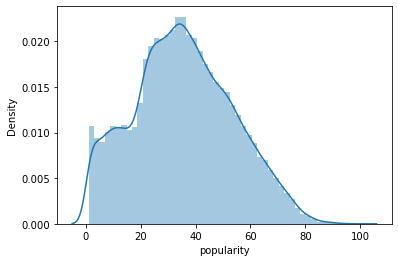

In [20]:
sample_df = df.select(['popularity']).sample(False, 0.5, 42)
sample_df = sample_df.toPandas()

sns.distplot(sample_df)
plt.xlabel('popularity') 
plt.show()

Overall, there is no major skew observed and popularity seems evenly distributed. There is a spike of songs with low popularity that causes the distribution to have two peaks. We dealt with this by looking at the songs with 0 or close to 0 popularity and noticed these songs were all released around 1920 (the earliest date in the dataset). We subset the songs to only contain songs that were released after 1925 so we have a more evenly distributed distribution for the target variable.

## Linear Regression Model

For our linear regression model, we scaled and standardized our features before combining them to a `VectorAssembler`. We then split the training and test dataset to a 80/20 split before fitting our model. We take the rmse and R-squared as metrics for model evaluation after testing on our test set.

**SCALING**

In [21]:
import pyspark.sql.functions as func
# Scale popularity
df1 = df.withColumn('popularity_final',
                   func.round(df['popularity']/100, 2)) \
        .withColumn('duration_min',
                   func.round(df['duration_ms']/60000, 2))\
        .withColumn('instrumentalness_final',
                   func.round(df['instrumentalness'] *1000, 2))

**SELECT AND STANDARDIZE FEATURES**

In [22]:
vars_to_keep = ['popularity_final',
                'acousticness',
                'danceability',
                'duration_min', 
                'energy',
                'instrumentalness_final',
                'liveness',
                'loudness',
                'speechiness',
                'tempo',
                'valence',
                'year']

# subset the dataframe on these predictors
df1 = df1.select(vars_to_keep)
df1.show(1)

+----------------+------------+------------+------------+------+----------------------+--------+--------+-----------+-----+-------+----+
|popularity_final|acousticness|danceability|duration_min|energy|instrumentalness_final|liveness|loudness|speechiness|tempo|valence|year|
+----------------+------------+------------+------------+------+----------------------+--------+--------+-----------+-----+-------+----+
|            0.23|       0.991|        0.69|        2.91| 0.164|                 886.0|   0.129| -18.657|     0.0451| 80.1|  0.579|1951|
+----------------+------------+------------+------------+------+----------------------+--------+--------+-----------+-----+-------+----+
only showing top 1 row



In [23]:
# Popularity_final V.S. Features
features= ['acousticness',
           'danceability',
           'duration_min',
           'energy', 
           'instrumentalness_final',
           'liveness',
           'loudness', 
           'speechiness',
           'tempo',
           'valence',
           'year']

assembler = VectorAssembler(
    inputCols = features, 
    outputCol = "features") 
df1 = assembler.transform(df1)

In [24]:
df1 = df1.select(["popularity_final",'features']) \
       .withColumnRenamed("popularity_final", 'label')
df1.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 0.23|[0.99099999666213...|
| 0.14|[0.98100000619888...|
| 0.19|[0.89700001478195...|
| 0.44|[0.875,0.30000001...|
| 0.41|[0.88899999856948...|
+-----+--------------------+
only showing top 5 rows



In [25]:
## Feature scaling
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", 
                                withStd=True, withMean=False)

# Fit the DataFrame to the scaler; this computes the mean, standard deviation of each feature
scaler = standardScaler.fit(df1)

# Transform the data in `df2` with the scaler
scaled_df = scaler.transform(df1)

In [26]:
# Split data into train set (80%), test set (20%) 
seed = 314
train_test = [0.8, 0.2]
train_data, test_data = scaled_df.randomSplit(train_test, seed)

In [27]:
train_data.show(3)

+-----+--------------------+--------------------+
|label|            features|     features_scaled|
+-----+--------------------+--------------------+
| 0.01|[1.17000001864653...|[3.33226606158317...|
| 0.01|[3.76999996660742...|[1.07373014877625...|
| 0.01|[9.31999995373189...|[0.00265442043118...|
+-----+--------------------+--------------------+
only showing top 3 rows



In [28]:
train_df1 = train_data

In [29]:
lr = LinearRegression(featuresCol = 'features', labelCol='label',
                      maxIter=10, regParam=0.0, elasticNetParam=0 )
model = lr.fit(train_df1)
prediction = model.transform(test_data)

print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [-0.04842300531556992,0.05358557620287193,0.002452016681405892,-0.07543727966945805,-9.940147463981474e-05,-0.09401758861974477,0.0032800158118337316,-0.04129346658570235,-4.8409029947023536e-05,-0.009394179751674264,0.003979083508693097]
Intercept: -7.4367791399057


In [30]:
trainingSummary = model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.152632
r2: 0.290996


In [31]:
train_data.describe().toPandas()

,summary,label
0,count,98598
1,mean,0.35590894338627593
2,stddev,0.18126865478510026
3,min,0.01
4,max,1.0


In [32]:
prediction = model.transform(test_data)
prediction.select("prediction","label","features").show(5)

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
| 0.5334659929488925| 0.01|[0.00875000003725...|
| 0.3993435178441924| 0.01|[0.37099999189376...|
|0.05602891256190645| 0.01|[0.99500000476837...|
| 0.3230987250848747| 0.04|[0.00190999999176...|
|0.26282140483273153| 0.04|[0.75300002098083...|
+-------------------+-----+--------------------+
only showing top 5 rows



In [33]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(prediction))

R Squared (R2) on test data = 0.284324


In [34]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 1
objectiveHistory: [0.0]
+--------------------+
|           residuals|
+--------------------+
| -0.3456567102861381|
|-0.46871693377393053|
| -0.4052326978143268|
| -0.3829102300496714|
| -0.3766321811458855|
| -0.4144099164501769|
|-0.21113918764563588|
| -0.4382435570953578|
|-0.21602513561236283|
|-0.21442958451613195|
|-0.10719016559717832|
| -0.1073889159903021|
| -0.3873716553795321|
| -0.4239581442661777|
| -0.4373727327170347|
| -0.4606898608427461|
| -0.5023621026610015|
| -0.4396224947202534|
| -0.3442655349748414|
|-0.47485021444807624|
+--------------------+
only showing top 20 rows



## Random Forest


In [35]:
# IMPORT
import numpy
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier

In [36]:
# PREPARE DATA
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
si_model = stringIndexer.fit(df1)
td = si_model.transform(df1)

In [37]:
# BUILD THE MODEL
rf = RandomForestClassifier(numTrees=11, maxDepth=2, labelCol="indexed", seed=314)
model = rf.fit(td)

In [38]:
# FEATURE IMPORTANCES
print(model.featureImportances)

(11,[0,3,4,6,7,10],[0.14972685915008468,0.09442190396143224,0.023789289206230333,0.07286467765959422,0.0032631725900500535,0.6559340974326084])


///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [39]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.util import MLUtils

In [40]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df1)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = df1.randomSplit([0.8, 0.2])

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures")

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print ("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


r2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(predictions))

rfModel = model.stages[1]
print (rfModel) # summary only

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
| 0.1935537043873065| 0.01|[1.17000001864653...|
|0.36962268987021263| 0.01|[9.31999995373189...|
|0.25683107438390407| 0.01|[0.98600000143051...|
|0.13382424149686678| 0.01|[0.99000000953674...|
| 0.1318715998377254| 0.02|[0.98199999332427...|
+-------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.141695
R Squared (R2) on test data = 0.383617
RandomForestRegressionModel: uid=RandomForestRegressor_a219ed6d73cb, numTrees=20, numFeatures=11


## Decision Tree

In [41]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
model = dt.fit(train_data)
prediction = model.transform(test_data)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.142023


In [42]:
model.featureImportances

SparseVector(11, {0: 0.0143, 1: 0.0001, 2: 0.0308, 3: 0.0002, 4: 0.1231, 5: 0.0089, 6: 0.0226, 7: 0.0007, 10: 0.7994})

In [43]:
df1.take(1)

[Row(label=0.23, features=DenseVector([0.991, 0.69, 2.91, 0.164, 886.0, 0.129, -18.657, 0.0451, 80.1, 0.579, 1951.0]))]

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [44]:
featureIndexer = VectorIndexer(inputCol = "features", outputCol = "indexedFeatures").fit(df1)

(trainingData, testData) = df1.randomSplit([0.8, 0.2])

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')

pipeline = Pipeline(stages =[featureIndexer, dt])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

In [45]:
predictions.select("prediction", "label", "features").show(10)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

r2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(predictions))

treeModel = model.stages[1]
# summary only
print(treeModel)

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
|0.41247964470762405| 0.01|[0.01090000011026...|
|0.09241071428571428| 0.01|[0.99500000476837...|
| 0.4504114049718053| 0.02|[0.01180000044405...|
|0.09241071428571428| 0.02|[0.75999999046325...|
|0.09241071428571428| 0.02|[0.98900002241134...|
|0.32174107142857133| 0.04|[0.00190999999176...|
|0.11648351648351644| 0.04|[0.75300002098083...|
|0.09241071428571428| 0.05|[0.98699998855590...|
| 0.4504114049718053| 0.08|[8.82999971508979...|
| 0.5102080209895052| 0.08|[0.00639000022783...|
+-------------------+-----+--------------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 0.141841
R Squared (R2) on test data = 0.382904
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_20701385767f, depth=5, numNodes=63, numFeatures=11


## Gradient-boosted Tree Regression

In [46]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10,
                   maxDepth=5, )
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'label', 'features').show(5)

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
|0.40814226447190466| 0.01|[0.00875000003725...|
| 0.2963777096582782| 0.01|[0.37099999189376...|
|0.08113530171405643| 0.01|[0.99500000476837...|
| 0.3865071716729513| 0.04|[0.00190999999176...|
|0.12370414456905021| 0.04|[0.75300002098083...|
+-------------------+-----+--------------------+
only showing top 5 rows



In [47]:
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.135898


///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [48]:
featureIndexer = VectorIndexer(inputCol = "features", outputCol = "indexedFeatures").fit(df1)

(trainingData, testData) = df1.randomSplit([0.8, 0.2])

gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10, maxDepth = 10)

pipeline = Pipeline(stages =[featureIndexer, gbt])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

In [49]:
predictions.select("prediction", "label", "features").show(10)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

r2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(predictions))

+--------------------+-----+--------------------+
|          prediction|label|            features|
+--------------------+-----+--------------------+
| 0.26330722456257916| 0.01|[3.76999996660742...|
|  0.2436701349473012| 0.01|[0.00875000003725...|
|-0.07190302751246969| 0.01|[0.37099999189376...|
|  0.3267052807974761| 0.02|[0.01180000044405...|
| 0.10627520187706231| 0.02|[0.98199999332427...|
| 0.10260881755739693| 0.02|[0.98900002241134...|
| 0.10189960186436517| 0.02|[0.98900002241134...|
|0.043436285112653655| 0.05|[0.79400002956390...|
| 0.10810036505228264| 0.05|[0.95899999141693...|
|0.018545291269823305| 0.07|[0.00400000018998...|
+--------------------+-----+--------------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 0.132945
R Squared (R2) on test data = 0.46585
